In [11]:
import os
import glob
import tifffile as tiff
import nd2
import matplotlib.pyplot as plt
import numpy as np
import sys
import skimage
# just to add cellprops module to the path.
new_path = '../../'
if new_path not in sys.path:
    sys.path.append(new_path)
import cellprops as cp
import scipy as sp
import pandas as pd
from ipywidgets import Layout, widgets
import pandas as pd
import importlib as il
import random
random.seed(42) # make the shuffles (and other random ops) repeatable by setting a speed.
def read_img(fname):
    if fname[-3:] == "tif":
        return tiff.imread(fname)
    if fname[-3:] == "nd2":
        return nd2.imread(fname)

### Kymograph Generator

Generates a kymograph for all nd2 files with a filamentous cell in the current directory.


In [12]:
# load ND2 images and an associated mask.

nd2_paths = ["0.0ara.nd2", "0.04ara.nd2", "0.02ara.nd2", "0.08ara.nd2", "0.16ara.nd2", "wt.tif"]

pc_channels = [0] * len(nd2_paths)
fl_channels = [1] * len(nd2_paths)
mask_paths =  [nd2_name[:-4] + "/dynamics_mask.tif" for nd2_name in nd2_paths]
kymo_paths = [nd2_name[:-4] + "/" for nd2_name in nd2_paths]


# Just to check that these files exist!
maskss = [tiff.imread(mask_path) for mask_path in mask_paths]
first_frames = [np.array(read_img(nd2_path)[0, chan]) for nd2_path, chan in zip(nd2_paths, fl_channels)]


<tifffile.TiffPage 0 @8> imagej_metadata failed with UnicodeDecodeError: 'utf-16-be' codec can't decode bytes in position 2180-2181: illegal encoding


In [16]:
### Setup annotation tools. 
def make_interactive(nd2_label, cell_idx): 
    # Initialize lists to store dropdown options and labelings
    dropdown_options = ['', 'no pattern', 'travelling', 'standing', 'oscillating', 'weak patterns', 'not a cell']
    out_path = "cell_annotations.csv"
    
    selected_label = widgets.Label()
    
    output = widgets.Output()

    # Define the function to handle the addition of new options
    def add_option(change):
        new_option = add_option_textbox.value
        if new_option and new_option not in dropdown_options:
            dropdown_options.append(new_option)
            dropdown.options = dropdown_options
            add_option_textbox.value = ''
    def annotate(change):
        new_val = change['new']
        
        try:
            df = pd.read_csv(out_path, index_col=None, )
            print(df)

        except FileNotFoundError: 
            df = pd.DataFrame(columns = ["nd2", "cell_idx", "annotation"])
        mask = (df["nd2"] == nd2_label) & (df["cell_idx"] == int(cell_idx))
        if mask.any():
            df.loc[mask, "annotation"] = new_val
        else:
            df.loc[len(df)] = [nd2_label, cell_idx, new_val]
        print(df)
        df.to_csv(out_path, index=False)

    
    # Create a dropdown widget
    dropdown = widgets.Dropdown(
        options=dropdown_options,
        description='Pattern:',
        value=dropdown_options[0]
    )
    
    # Create a textbox widget
    add_option_textbox = widgets.Text(
        description='New Pattern:',
        placeholder='Type new option here'
    )
    
    # Create a button to add new options
    add_option_button = widgets.Button(description='Add Option')
    add_option_button.on_click(add_option)
    dropdown.observe(annotate, names = "value")
    
    option_widget = widgets.VBox([dropdown, add_option_textbox, add_option_button])

    return option_widget


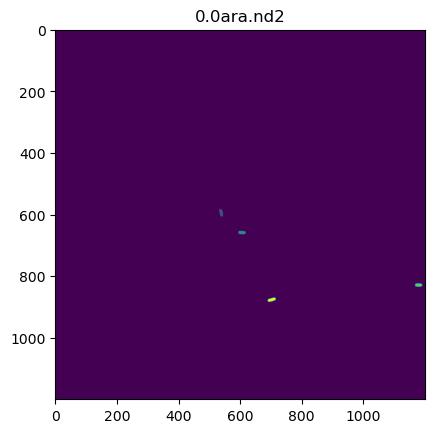

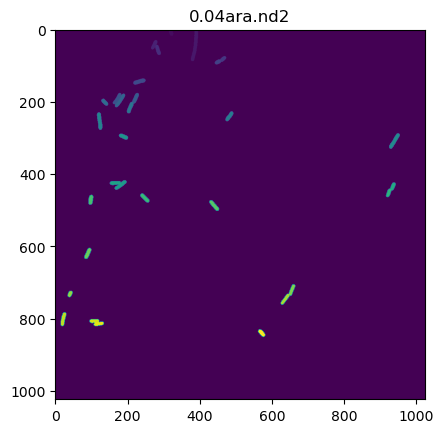

too short of a center line
too short of a center line


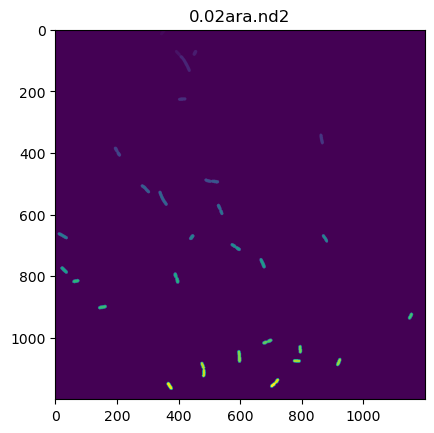

too short of a center line


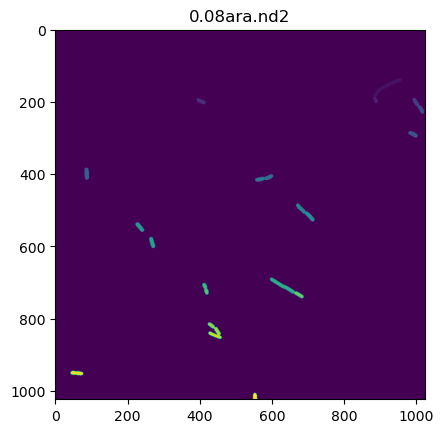

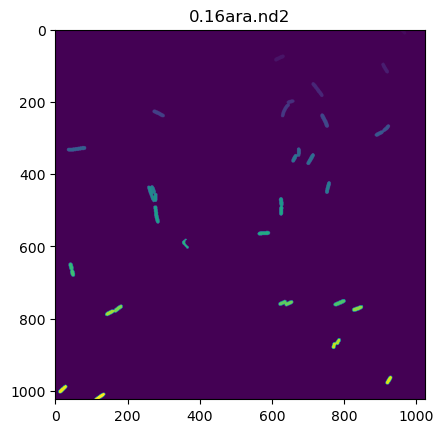

<tifffile.TiffPage 0 @8> imagej_metadata failed with UnicodeDecodeError: 'utf-16-be' codec can't decode bytes in position 2180-2181: illegal encoding


too short of a center line


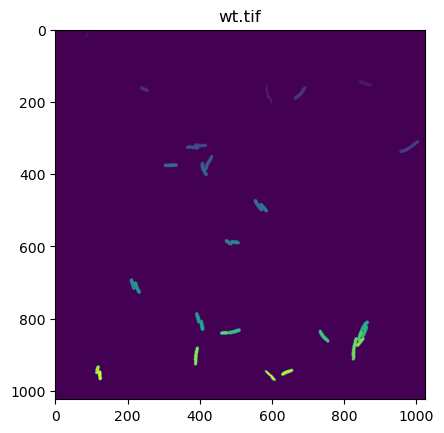

too short of a center line


In [17]:

for nd2_path, mask_path, channel in zip(nd2_paths, mask_paths, fl_channels):
    path = nd2_path[:-4] + "/"
    frames = read_img(nd2_path)[:, channel]
    masks = tiff.imread(mask_path)
    plt.imshow(masks)
    plt.title(nd2_path)
    plt.show()

    # only annotate the first <=10 cells.
    idx = 0
    
    # shuffle the cells so we don't get some kind of bias from
    # heterogenous edge illumination
    cells_and_kymos = list(zip(*cp.gen_kymos(frames, masks)))
    random.shuffle(cells_and_kymos)
    for cell, kymo in cells_and_kymos:
        # photobleaching correction, write out the kymo
        corrected_kymo = cp.bleach_correct(kymo)
        out_path = f"{path}/kymo_{cell}.tif"
        tiff.imwrite(f"{path}/kymo_{cell}.tif", corrected_kymo)

        # only annotate the first ~10 cells.
        if idx >= 10:
            continue
        idx += 1
        
        # visualize center line
        cur_mask = masks == cell
        r1, r2, c1, c2 = cp.bbox(cur_mask)
        walk = cp.gen_center_line(cur_mask)
        walk[:, 0] -= r1
        walk[:, 1] -= c1
        
        output = widgets.Output()
        with output:
            fig, ax = plt.subplots(1, 3)
            ax[0].plot(walk[:,1], walk[:,0], label='walk')
            ax[0].imshow(cur_mask[r1:r2+1, c1:c2+1])
            ax[1].imshow(kymo)
            ax[2].imshow(corrected_kymo)
    
            plt.title(f"{out_path}")
            plt.show()
        option_widget = make_interactive(nd2_path, cell)

        # Display the plot and widgets side by side
        display(widgets.HBox([output, option_widget],  
                             layout=Layout(display='flex', flex_flow='row', align_items='center')))



#### 